# Análise de Regressão Logística: O Impacto da Cor da Parede na Agilidade dos Laudos

## Dataset: [Link](./data/dasa-final.csv)

**Objetivo:** Investigar a crença de que pintar a parede da sala de coleta de laranja está associado a uma maior agilidade na entrega de laudos.

**Problema de Negócio:** "A parede da sala de coleta pintada de laranja realmente ajuda a agilizar os laudos?" (Cris, Experiência do Paciente)

**Metodologia:** Utilizaremos um modelo de Regressão Logística para determinar se a variável `cor_parede_coleta` tem um impacto estatisticamente significativo na probabilidade de um laudo ser liberado rapidamente.

## Importando Bibliotecas & Helpers

In [16]:
from utils.helpers import generate_unique_values_table, get_dimensions, COLUNAS_ORDENADAS
from IPython.display import display, Markdown

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style="whitegrid")

## Lendo o dataset

In [17]:
df_dasa = pd.read_csv('./data/dasa-final.csv', sep=',')

In [18]:
df_dasa = df_dasa[COLUNAS_ORDENADAS]
display(Markdown(f"**Dimensões:** {get_dimensions(df_dasa)}"))

display(df_dasa.head())


**Dimensões:** 1.000 registros, 26 colunas

,unidade,mes,dia_fechamento,pacientes_dia,exames_realizados,tipo_exame,turno_mais_movimentado,hora_inicio_turno,temp_medio_exame,tempo_entrega_resultado,...,cpf_biomedico,cor_jaleco_funcionario,mes_nascimento_biomedico,musica_ambiente,cheiro_ambiente,aromatizador_eucalipto,elemento_decorativo,cor_parede_laboratorio,cor_parede_coleta,janela_virada_para
0,Unidade C,jun/2025,23,52,72,sangue,manhã,9,20.1,22.17,...,97069094493,verde_limao,set,nenhuma,café,não,cacto,verde,verde,leste
1,Unidade E,mai/2025,3,56,48,imagem,tarde,7,16.6,33.48,...,87320570731,azul_bebe,nov,nenhuma,lavanda,não,nenhum,azul,amarela,nenhuma
2,Unidade A,mai/2025,8,44,67,NaN,manhã,12,18.6,41.57,...,37306026087,branco,mar,pagode_90s,café,não,nenhum,cinza,laranja,norte
3,Unidade D,fev/2025,17,51,57,imagem,noite,8,10.0,34.92,...,56594789692,azul_bebe,nov,nenhuma,lavanda,não,cacto,grafite,azul_cobalto,nenhuma
4,Unidade D,jul/2024,29,56,69,urina,noite,12,24.4,32.59,...,38100952961,verde_limao,jul,nenhuma,café,não,vaso_bambu,azul,verde,leste


## Formatando os dados

1. Converter colunas numéricas para tipos mais eficientes  
2. Converter colunas binárias ('sim'/'não') para booleanos  
3. Limpar erros de digitação em colunas categóricas
4. Converter colunas de texto para o tipo 'category'  
5. Tratar valores ausentes  
6. Verificar os novos tipos de dados  

In [19]:
df_dasa_formatted = df_dasa.copy()

df_dasa_formatted['pacientes_dia'] = df_dasa['pacientes_dia'].astype('int16')
df_dasa_formatted['exames_realizados'] = df_dasa['exames_realizados'].astype('int16')
df_dasa_formatted['quantidade_refrigeradores'] = df_dasa['quantidade_refrigeradores'].astype('int8')
df_dasa_formatted['hora_inicio_turno'] = df_dasa['hora_inicio_turno'].astype('int8')
df_dasa_formatted['dia_fechamento'] = df_dasa['dia_fechamento'].astype('int8')

mapeamento_bool = {'sim': True, 'não': False}
df_dasa_formatted['protocolo_emergencia'] = df_dasa['protocolo_emergencia'].map(mapeamento_bool).astype('boolean')
df_dasa_formatted['aromatizador_eucalipto'] = df_dasa['aromatizador_eucalipto'].map(mapeamento_bool).astype(bool)

df_dasa_formatted['tipo_exame'] = df_dasa_formatted['tipo_exame'].replace({'??!!##': np.nan})
df_dasa_formatted['cor_parede_laboratorio'] = df_dasa_formatted['cor_parede_laboratorio'].replace({'GRAFITE #007': 'grafite'})

df_dasa_formatted['cpf_biomedico'] = df_dasa_formatted['cpf_biomedico'].astype('string')

colunas_categoricas = [
    'unidade', 'mes', 'tipo_exame', 'turno_mais_movimentado', 'direcao_centrifuga',
    'alinhamento_refrigeradores', 'cor_parede_laboratorio', 'cor_parede_coleta',
    'cheiro_ambiente', 'musica_ambiente', 'cor_jaleco_funcionario',
    'elemento_decorativo', 'janela_virada_para', 'mes_nascimento_biomedico',
    'chefe_setor', 'tipo_refrigeracao'
]

for col in colunas_categoricas:
    df_dasa_formatted[col] = df_dasa_formatted[col].astype('category')

df_dasa_formatted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   unidade                     1000 non-null   category
 1   mes                         1000 non-null   category
 2   dia_fechamento              1000 non-null   int8    
 3   pacientes_dia               1000 non-null   int16   
 4   exames_realizados           1000 non-null   int16   
 5   tipo_exame                  911 non-null    category
 6   turno_mais_movimentado      1000 non-null   category
 7   hora_inicio_turno           1000 non-null   int8    
 8   temp_medio_exame            920 non-null    float64 
 9   tempo_entrega_resultado     1000 non-null   float64 
 10  protocolo_emergencia        920 non-null    boolean 
 11  quantidade_refrigeradores   1000 non-null   int8    
 12  tipo_refrigeracao           1000 non-null   category
 13  alinhamento_refrige

### Análise Exploratória

### Valores Nulos por Coluna

In [20]:
display(df_dasa.isnull().sum().to_frame("nulos"))

,nulos
unidade,0
mes,0
dia_fechamento,0
pacientes_dia,0
exames_realizados,0
tipo_exame,79
turno_mais_movimentado,0
hora_inicio_turno,0
temp_medio_exame,80
tempo_entrega_resultado,0


### Valores únicos por categoria

In [21]:
display(Markdown(generate_unique_values_table(df_dasa_formatted)))


numerical_cols = df_dasa_formatted.select_dtypes(
    include=["int16", "int8", "int64", "float64"]
).columns
categorical_cols = df_dasa_formatted.select_dtypes(include=["category", "bool", "boolean"]).columns


| Coluna                     | Valores |
|----------------------------|---------|
| unidade                      | Unidade E, Unidade D, Unidade A, Unidade C, Unidade B, Unidade F |
| mes                          | mar/2024, ago/2024, ago/2025, nov/2025, set/2024, jan/2025, mai/2024, out/2024, jul/2024, jan/2024, jun/2025, fev/2024, nov/2024, dez/2025, set/2025, mai/2025, out/2025, dez/2024, abr/2024, mar/2025, jun/2024, fev/2025, jul/2025, abr/2025 |
| tipo_exame                   | sangue, urina, imagem, covid, genético, alergia, hormonal, NaN |
| turno_mais_movimentado       | manhã, tarde, noite |
| protocolo_emergencia         | False, True, NaN |
| tipo_refrigeracao            | climatizada, seca, umida, controlada |
| alinhamento_refrigeradores   | lado_a_lado, dispersos, em_L |
| direcao_centrifuga           | oeste, leste, sul, norte |
| chefe_setor                  | Carlos, Julia, Nina, Marcos, Eduardo, Bianca, Ana, José, 1234, 1113 |
| cor_jaleco_funcionario       | azul_bebe, verde_limao, branco, vinho |
| mes_nascimento_biomedico     | jul, jan, ago, nov, dez, jun, mai, out, set, mar, abr, fev |
| musica_ambiente              | nenhuma, rock, jazz, pagode_90s |
| cheiro_ambiente              | café, eucalipto, lavanda, nenhum |
| aromatizador_eucalipto       | False, True |
| elemento_decorativo          | nenhum, vaso_bambu, cacto, samambaia |
| cor_parede_laboratorio       | amarela, azul, cinza, grafite, laranja, verde, branca, vinho, azul_cobalto |
| cor_parede_coleta            | branca, azul_cobalto, amarela, roxa, laranja, verde |
| janela_virada_para           | nenhuma, oeste, sul, leste, norte |


### Colunas Numéricas vs Categóricas

In [22]:
variable_type_summary = (
    """
| Tipo de Variável | Colunas |
|------------------|---------|
""" +
    f"| Numéricas        | {', '.join(numerical_cols)} |\n"
    f"| Categóricas      | {', '.join(categorical_cols)} |\n"
)

display(Markdown(variable_type_summary))


| Tipo de Variável | Colunas |
|------------------|---------|
| Numéricas        | dia_fechamento, pacientes_dia, exames_realizados, hora_inicio_turno, temp_medio_exame, tempo_entrega_resultado, quantidade_refrigeradores |
| Categóricas      | unidade, mes, tipo_exame, turno_mais_movimentado, protocolo_emergencia, tipo_refrigeracao, alinhamento_refrigeradores, direcao_centrifuga, chefe_setor, cor_jaleco_funcionario, mes_nascimento_biomedico, musica_ambiente, cheiro_ambiente, aromatizador_eucalipto, elemento_decorativo, cor_parede_laboratorio, cor_parede_coleta, janela_virada_para |


### Boxplots colunas numéricas

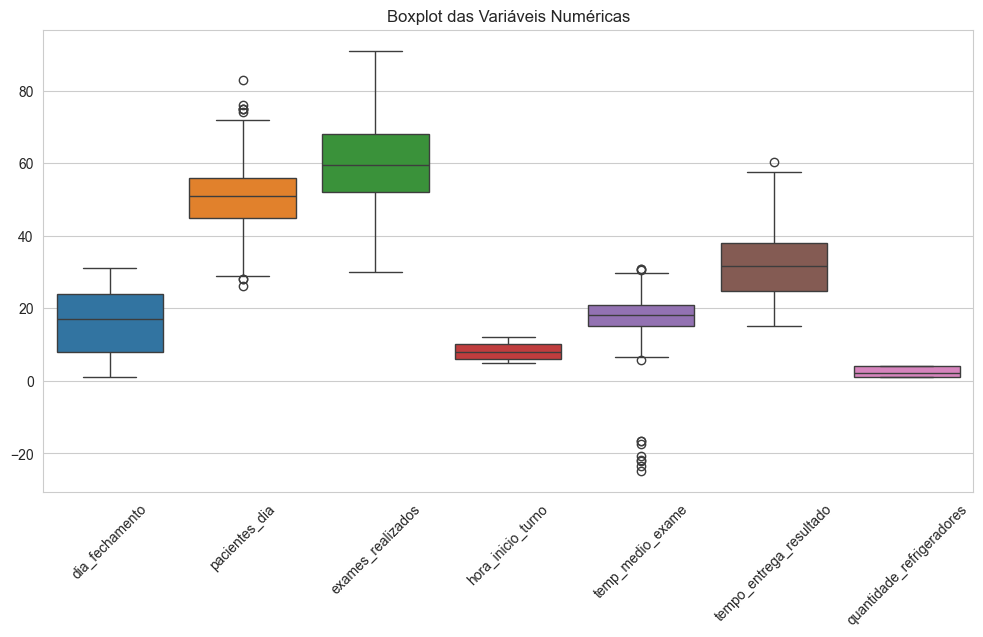

### Mínimo e Máximo das Variáveis Numéricas

| Coluna | Mínimo | Máximo |
|--------|--------|--------|
| dia_fechamento | 1 | 31 |
| pacientes_dia | 26 | 83 |
| exames_realizados | 30 | 91 |
| hora_inicio_turno | 5 | 12 |
| temp_medio_exame | -24.8 | 30.9 |
| tempo_entrega_resultado | 15.01 | 60.21 |
| quantidade_refrigeradores | 1 | 4 |


In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_dasa_formatted[numerical_cols])
plt.title("Boxplot das Variáveis Numéricas")
plt.xticks(rotation=45)
plt.show()

min_max_table = "| Coluna | Mínimo | Máximo |\n|--------|--------|--------|\n"
for col in numerical_cols:
    min_val = df_dasa_formatted[col].min()
    max_val = df_dasa_formatted[col].max()
    min_max_table += f"| {col} | {min_val} | {max_val} |\n"

display(Markdown("### Mínimo e Máximo das Variáveis Numéricas"))
display(Markdown(min_max_table))

### Correlações das colunas

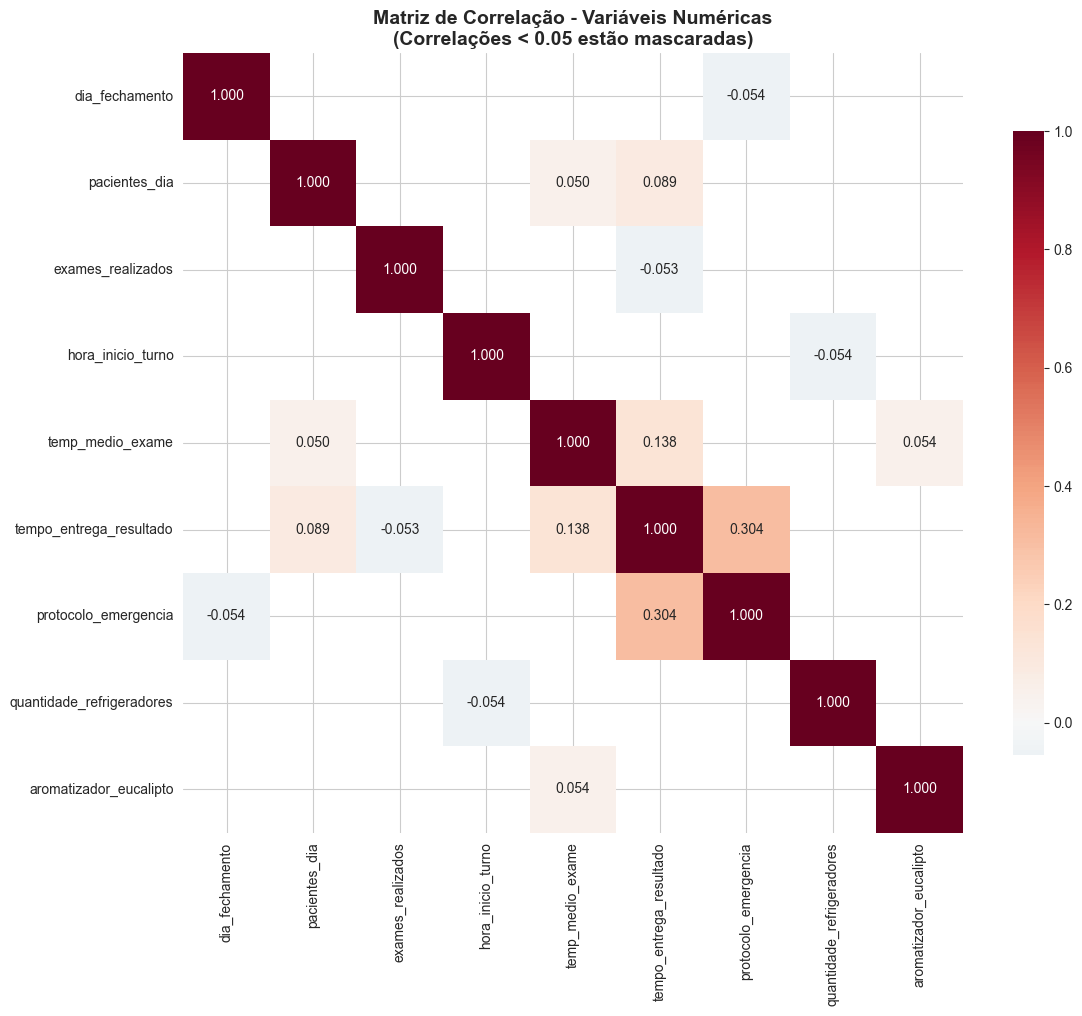

In [24]:
correlation_matrix = df_dasa_formatted.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
mask = correlation_matrix.abs() < 0.05
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="RdBu_r",
    center=0,
    square=True,
    fmt=".3f",
    cbar_kws={"shrink": 0.8},
    mask=mask,
)
plt.title(
    "Matriz de Correlação - Variáveis Numéricas\n(Correlações < 0.05 estão mascaradas)",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.savefig('./imgs/correlation_matrix_dasa.png')
plt.show()

# **PROBLEMAS (1 - 3)**

## **PROBLEMA 1**: Turno da Manhã, Luciana, Diretora de Operações 
### “Como posso aumentar a chance dos laudos saírem no mesmo turno da coleta (até 6h)?” 
* Explique em um parágrafo: O que a análise mostra como principal fator de sucesso para entregar laudos nesse prazo? O que recomenda à diretoria?

### Criação da variável alvo `laudo_6h`

In [31]:
df_laudo_6h = df_dasa_formatted.copy()
df_laudo_6h['laudo_no_prazo'] = (df_laudo_6h['tempo_entrega_resultado'] <= 6).astype(int)

display(
    df_laudo_6h['laudo_no_prazo']
    .value_counts()
    .rename_axis('Laudo no Prazo')
    .to_frame('Quantidade')
    .reset_index()
)

,Laudo no Prazo,Quantidade
0,0,1000


## **PROBLEMA 2**: Exame de Imagem, Renato, Gestor da Unidade Central
### “O que realmente aumenta o risco dos exames de imagem atrasarem mais de 36 horas?”
* Explique em um parágrafo: Quais fatores mais pesam? O que deve ser ajustado/processado para evitar atrasos?

In [26]:
df_imagem = df_dasa_formatted[df_dasa_formatted['tipo_exame'] == 'imagem'].copy()
df_imagem = df_imagem.dropna()


df_imagem['atraso_36h'] = (df_imagem['tempo_entrega_resultado'] > 36).astype(int)
display(Markdown(f"Taxa de atrasos (> 36h): **{df_imagem['atraso_36h'].mean():.2%}**"))
display(Markdown(f"Número de atrasos: **{df_imagem['atraso_36h'].sum()}** de **{len(df_imagem)}**"))

display(Markdown(f"Dimensões: {get_dimensions(df_imagem)}"))

Taxa de atrasos (> 36h): **41.51%**

Número de atrasos: **44** de **106**

Dimensões: 106 registros, 27 colunas

## **PROBLEMA 3**: Parede Laranja, Cris, Experiência do Paciente
### “A parede da sala de coleta pintada de laranja realmente ajuda a agilizar os laudos?”
* Explique em um parágrafo: Existe fundamento nessa crença? O que sua análise recomenda (ou desrecomenda)?

In [29]:
df_parede = df_dasa_formatted.copy()
df_parede = df_parede.dropna()

df_parede['parede_laranja'] = (df_parede['cor_parede_coleta'] == 'laranja').astype(int)

display(Markdown(f"Dimensões após remover nulos: {get_dimensions(df_parede)}"))

Dimensões após remover nulos: 776 registros, 27 colunas